# Train Single Agent on Mountain Car

This notebook can be used to train a single DAIF agent on the Mountain Car environment. Code cells to use either the DDPG or A2C for habitual action are available and deciding between each is a matter of commenting out the appropriate cell.

In [1]:
import gym
import pandas as pd

from agent_and_models.vae import VAE, create_decoder, create_encoder
from agent_and_models.transition_gru import TransitionGRU
from agent_and_models.daif_agent import DAIFAgent
from agent_and_models.prior_preferences_model import PriorPreferencesModel
from agent_and_models.a2c import PolicyGradientNetwork
from agent_and_models.ddpg import *

In [2]:
from util import transform_observations, test_policy, habit_policy
from train_agent import train_single_agent

In [3]:
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [4]:
pln_hrzn = 5
latent_dim = 2
obs_dim = 2

# make the VAE
enc = create_encoder(2, latent_dim, [20])
dec = create_decoder(latent_dim, 2, [20])
vae = VAE(enc, dec, latent_dim,  [0]*latent_dim, [0.3]*latent_dim, train_epochs=2, show_training=False)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# make the TRANSITION
tran = TransitionGRU(latent_dim, 1, 2*pln_hrzn*latent_dim, 2, train_epochs=2, show_training=False)
tran.compile(optimizer=tf.keras.optimizers.Adam())

# make the PRIOR NET
prior_model = PriorPreferencesModel(latent_dim, output_dim=1, show_training=False, use_tanh_on_output=False)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

## Uncomment for using A2C

In [5]:
# make the HABIT ACTION NET
habit_net = PolicyGradientNetwork(latent_dim, 1, [16, 16], train_epochs=2, show_training=False)
habit_net.compile(optimizer=tf.keras.optimizers.Adam())

daifa = DAIFAgent(prior_model,
                           vae,
                           tran,
                           habit_net,
                           planning_horizon=pln_hrzn,
                           use_efe_extrinsic=True,
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_habit_net=True,
                           train_prior_model=True,
                           train_tran=True,
                           train_during_episode=True,
                           train_with_replay=True,
                           use_habit_policy=True,
                           habit_model_type="A2C",
                           uncertainty_tolerance=0.1,
                           min_rewards_needed_to_train_prior=-10,
                           prior_model_scaling_factor=1)

## Uncomment for using DDPG

In [6]:
# # # make the DDPG HABIT ACTION NET
# actor_model = get_actor(2, 1)
# critic_model = get_critic(2, 1)
# target_actor = get_actor(2, 1)
# target_critic = get_critic(2, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)
#
#
# daifa = DAIFAgent(prior_model,
#                            vae,
#                            tran,
#                            habit_net,
#                            planning_horizon=pln_hrzn,
#                            use_efe_extrinsic=True,
#                            use_kl_intrinsic=True,
#                            use_FEEF=False,
#                            train_habit_net=True,
#                            train_prior_model=True,
#                            train_tran=True,
#                            train_during_episode=True,
#                            train_with_replay=True,
#                            use_habit_policy=True,
#                            habit_model_type="DDPG",
#                            uncertainty_tolerance=0.1,
#                            min_rewards_needed_to_train_prior=-10,
#                            prior_model_scaling_factor=1)

In [7]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_one = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=60, render_env=False)

Episode 1


2022-10-21 13:40:37.018003: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Number of habit choices: 10
Number of actions total: 167
training on full data
No Success
Episode 2
Number of habit choices: 5
Number of actions total: 49
training on full data
Success in episode 2 at time step 289 with reward 95.86361524353285
Episode 3
Number of habit choices: 10
Number of actions total: 167
training on full data
No Success
Episode 4
Number of habit choices: 1
Number of actions total: 58
training on full data
Success in episode 4 at time step 346 with reward 94.85523349568679
Episode 5
Number of habit choices: 0
Number of actions total: 15
training on full data
Success in episode 5 at time step 88 with reward 98.86584516765541
Episode 6
Number of habit choices: 5
Number of actions total: 22
training on full data
Success in episode 6 at time step 128 with reward 98.42783387695783
Episode 7
Number of habit choices: 3
Number of actions total: 79
tr

In [8]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.601244,414,69
1,99.621316,510,85
2,99.641981,474,79
3,99.728005,720,120
4,99.756397,648,108
5,99.580927,594,99
6,-0.244416,1002,167
7,99.762964,474,79
8,99.597877,546,91
9,99.738045,318,53


In [9]:
daifa.train_vae = False
daifa.model_vae.show_training = False

daifa.train_habit_net = True
daifa.train_after_exploring = True
daifa.use_fast_thinking = True
daifa.uncertainty_tolerance = 0.1

In [10]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_two = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=90, render_env=False)

Episode 1
Number of habit choices: 12
Number of actions total: 28
training on full data
Success in episode 1 at time step 164 with reward 98.78494618445629
Episode 2
Number of habit choices: 5
Number of actions total: 14
training on full data
Success in episode 2 at time step 81 with reward 99.32998263593984
Episode 3
Number of habit choices: 17
Number of actions total: 28
training on full data
Success in episode 3 at time step 163 with reward 99.00106241943816
Episode 4
Number of habit choices: 12
Number of actions total: 28
training on full data
Success in episode 4 at time step 166 with reward 98.58665893839922
Episode 5
Number of habit choices: 7
Number of actions total: 14
training on full data
Success in episode 5 at time step 81 with reward 99.33437649424982
Episode 6
Number of habit choices: 13
Number of actions total: 32
training on full data
Success in episode 6 at time step 191 with reward 98.35535931955931
Episode 7
Number of habit choices: 18
Number of actions total: 28
tr

In [11]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.278257,246,41
1,99.255963,324,54
2,99.354313,246,41
3,98.990015,480,80
4,99.035129,462,77
5,99.262183,246,41
6,99.123786,690,115
7,99.309068,240,40
8,99.236442,318,53
9,99.416598,294,49


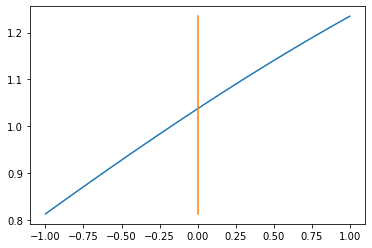

In [12]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

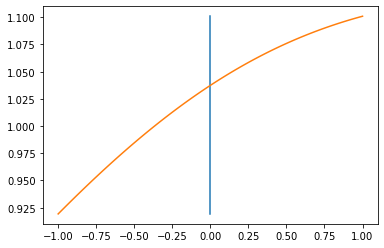

In [13]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

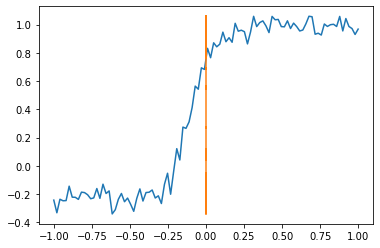

In [14]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_habit_policy(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

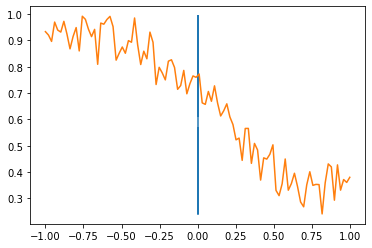

In [15]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_habit_policy(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [16]:
env = gym.make('MountainCarContinuous-v0')
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 5, daifa.agent_time_ratio, show_env=True)
res


KeyboardInterrupt



In [17]:
full_results = pd.concat([results_one, results_two])
full_results = full_results.reset_index(drop=True)
full_results

,episode,success,sim_steps,VFE_post_run,noise_stddev,percent_use_fast_thinking,total_reward,agent_time_ratio
0,0,False,999,53.088947,"[0.05, 0.05]",0.059880,-14.746116,6
1,1,True,289,68.332474,"[0.05, 0.05]",0.102041,95.863615,6
2,2,False,999,51.360619,"[0.05, 0.05]",0.059880,-14.382629,6
3,3,True,346,65.760208,"[0.05, 0.05]",0.017241,94.855233,6
4,4,True,88,69.523987,"[0.05, 0.05]",0.000000,98.865845,6
...,...,...,...,...,...,...,...,...
145,85,True,162,7.457077,"[0.05, 0.05]",0.666667,98.845766,6
146,86,True,171,10.279743,"[0.05, 0.05]",0.551724,98.301972,6
147,87,True,152,8.516612,"[0.05, 0.05]",0.461538,98.514030,6
148,88,True,86,7.471054,"[0.05, 0.05]",0.466667,99.117424,6


In [18]:
T = np.arange(len(full_results))

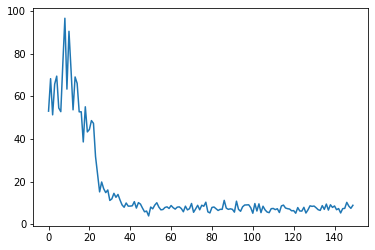

In [19]:
plt.plot(T, full_results.VFE_post_run)

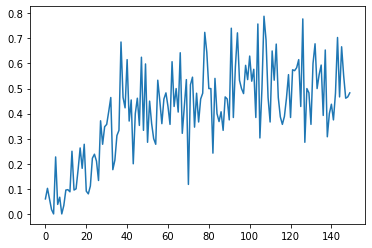

In [20]:
T = np.arange(len(full_results))
plt.plot(T, full_results.percent_use_fast_thinking)

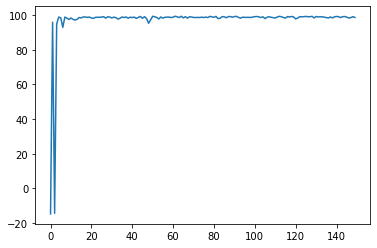

In [21]:
plt.plot(T, full_results.total_reward)

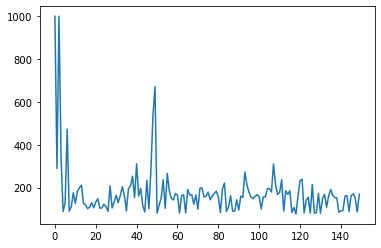

In [22]:
plt.plot(T, full_results.sim_steps)